In [25]:
!pip install dataretrieval

In [26]:
import pandas as pd
import dataretrieval.nwis as nwis


In [59]:
# specify the USGS site code for which we want data
site = '11447650'

# specify parameter code to get turbidity data
parameter_code = '63680'  # Turbidity, in FNU

# set a desirable date range
start_date = '1948-10-01'
end_date = '2025-08-02'


In [61]:
# check info on a parameter code
parameter_codes = nwis.get_pmcodes(['63680'])
# print(parameter_codes)

In [62]:
# get basic info about the site
site_info = nwis.get_record(sites=site)
print(site_info.columns)

Index(['site_no', '00010_right bank pump stand',
       '00010_right bank pump stand_cd', '00010_bgc project, [east fender',
       '00010_bgc project, [east fender_cd', '00060', '00060_cd',
       '00065_primary', '00065_primary_cd', '00095_bgc project, [east fender',
       '00095_bgc project, [east fender_cd', '00300_bgc project, [east fender',
       '00300_bgc project, [east fender_cd', '00301_bgc project, [computed',
       '00301_bgc project, [computed_cd', '00400_bgc project, [east fender',
       '00400_bgc project, [east fender_cd', '00480_bgc project, [east fender',
       '00480_bgc project, [east fender_cd', '32295_bgc project, [east fender',
       '32295_bgc project, [east fender_cd', '32316_bgc project',
       '32316_bgc project_cd', '63680_median ts087: ysi model 6136',
       '63680_median ts087: ysi model 6136_cd',
       '63680_bgc project, [east fender', '63680_bgc project, [east fender_cd',
       '72137', '72137_cd', '72255', '72255_cd', '99133_bgc project',
   

In [63]:
# get instantaneous values (iv)
df, metadata = nwis.get_iv(
    sites=site,
    parameterCd=parameter_code,
    start=start_date,
    end=end_date
)


In [66]:
# remove indexing so that we can access the column and column name
df = df.reset_index()

# create a subset of relevant data and data quality flag columns
# choose only turbidity - parameter code 63680:
  # Turbidity, water, unfiltered, monochrome near infra-red LED light,
  # 780-900 nm, detection angle 90 +-2.5 degrees, formazin nephelometric units (FNU)

df_filtered = df[[col for col in df.columns if '63680' in col or 'site_no' in col or 'datetime' in col]]

In [67]:
# display data
print(df_filtered.head())
print("\nMetadata:")
print(metadata)

df_filtered.columns

                   datetime   site_no  63680_median ts087: ysi model 6136  \
0 2009-12-03 23:00:00+00:00  11447650                                 4.7   
1 2009-12-03 23:15:00+00:00  11447650                                 4.0   
2 2009-12-03 23:30:00+00:00  11447650                                 3.8   
3 2009-12-03 23:45:00+00:00  11447650                                 4.4   
4 2009-12-04 00:00:00+00:00  11447650                                 4.0   

  63680_median ts087: ysi model 6136_cd  63680_bgc project, [east fender  \
0                                     A                              NaN   
1                                     A                              NaN   
2                                     A                              NaN   
3                                     A                              NaN   
4                                     A                              NaN   

  63680_bgc project, [east fender_cd  
0                                NaN  
1 

Index(['datetime', 'site_no', '63680_median ts087: ysi model 6136',
       '63680_median ts087: ysi model 6136_cd',
       '63680_bgc project, [east fender',
       '63680_bgc project, [east fender_cd'],
      dtype='object')

In [68]:
# turbidity was measured by two types of equipment, but not simultanteously
  # here is the code to merge those columns into one
  # to have all turbidity values in one column
  # and corresponding data quality flags in another column

df_filtered['turbidity'] = df_filtered['63680_median ts087: ysi model 6136'].combine_first(df_filtered['63680_bgc project, [east fender'])
df_filtered['turbidity_cd'] = df_filtered['63680_median ts087: ysi model 6136_cd'].combine_first(df_filtered['63680_bgc project, [east fender_cd'])


In [69]:
# drop initial columns
df_filtered = df_filtered.drop(columns=[
    '63680_median ts087: ysi model 6136',
       '63680_median ts087: ysi model 6136_cd',
       '63680_bgc project, [east fender',
       '63680_bgc project, [east fender_cd']
)


In [70]:
# clean data to keep only with "Approved" flag
df_clean = df_filtered[df_filtered['turbidity_cd'].isin(['A', '']) | df_filtered['turbidity_cd'].isna()]


# check this new dataframe
display(df_clean.head(5))
display(df_clean.tail(5))

,datetime,site_no,turbidity,turbidity_cd
0,2009-12-03 23:00:00+00:00,11447650,4.7,A
1,2009-12-03 23:15:00+00:00,11447650,4.0,A
2,2009-12-03 23:30:00+00:00,11447650,3.8,A
3,2009-12-03 23:45:00+00:00,11447650,4.4,A
4,2009-12-04 00:00:00+00:00,11447650,4.0,A


,datetime,site_no,turbidity,turbidity_cd
504697,2025-01-06 15:15:00+00:00,11447650,50.5,A
504698,2025-01-06 15:30:00+00:00,11447650,49.8,A
504699,2025-01-06 15:45:00+00:00,11447650,53.4,A
504700,2025-01-06 16:00:00+00:00,11447650,51.1,A
504701,2025-01-06 16:15:00+00:00,11447650,50.7,A


In [71]:
# check how many rows were dropped
original_count = len(df)
clean_count = len(df_clean)

dropped_count = original_count - clean_count
dropped_percent = (dropped_count / original_count) * 100

print(f"Original rows: {original_count}")
print(f"Clean (approved) rows: {clean_count}")
print(f"Dropped rows: {dropped_count} ({dropped_percent:.2f}%)")

Original rows: 524648
Clean (approved) rows: 504702
Dropped rows: 19946 (3.80%)


/tmp/ipython-input-240682254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])


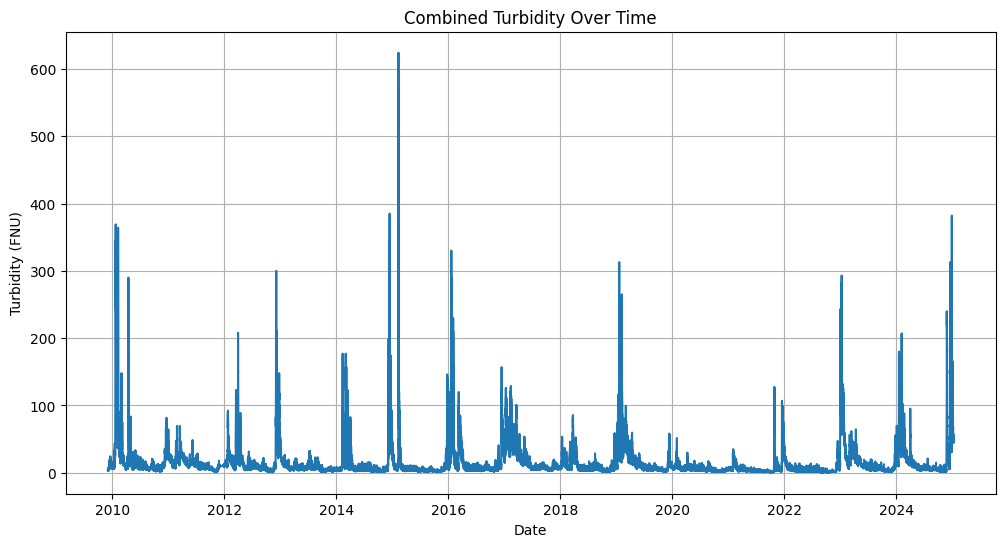

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'datetime' column is in datetime format
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# Set the 'datetime' column as the index for time series plotting
df_clean.set_index('datetime', inplace=True)

# Create the time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clean, y='turbidity', x=df_clean.index)
plt.title('Combined Turbidity Over Time')
plt.xlabel('Date')
plt.ylabel('Turbidity (FNU)')
plt.grid(True)
plt.show()

In [74]:
df_clean.to_csv(f"{site}_raw_iv_turb.csv")